In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle


from DrlLibs.training import create_parallel_environment, train_drl_agent
from DrlLibs.evaluate import evaluate_drl_agent
from DrlLibs import create_environment, check_env
from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv
from DrlLibs.visualize import plot_training_results








In [2]:
def main(simParams, simEnv, save_path, agent_name, algorithm_name: str = "SAC", 
         obvMode="perfect", total_timesteps: int = 20000, 
         timesteps_per_episode: int = 5000, n_envs: int = 4,
         early_stop_threshold: float = 0.05, min_steps_before_stop: int = 1000,
         moving_avg_window: int = 100):
    """Main function to train and evaluate a DRL agent with early stopping based on moving average."""
    
    
    print("="*80)
    print(f"{algorithm_name} as Agent config{agent_name}'s Training and Evaluation")
    print("="*80)
    
    # Create environment (single or parallel)
    print("Creating environment...")
    env = create_parallel_environment(simParams, simEnv, obvMode, 
                                    timesteps_per_episode, n_envs)
    
    # Check environment (only for single env)
    if n_envs == 1:
        print("Checking environment...")
        check_env(env.unwrapped)
        print("Environment check passed!")
    else:
        print(f"Created {n_envs} parallel environments")
    
    model, callback, training_time = train_drl_agent(
        algorithm_name, env, total_timesteps, save_path, agent_name,
        early_stop_threshold=early_stop_threshold, 
        min_steps_before_stop=min_steps_before_stop,
        moving_avg_window=moving_avg_window
    )
    
    
    # Create a clean single environment for evaluation
    print("Creating evaluation environment...")
    eval_env = create_environment(simParams, simEnv, obvMode, timesteps_per_episode)
    
    # Evaluate DRL agent
    eval_results = evaluate_drl_agent(model, eval_env, algorithm_name)
    
    # Close evaluation environment
    eval_env.close()
    
    # Plot training results
    print("\nGenerating visualizations...")
    try:
        plot_training_results(callback, eval_results, algorithm_name, save_plots=True)
    except Exception as e:
        print(f"Visualization failed: {e}")
        print("Training data summary:")
        if hasattr(callback, 'cumulative_rewards') and callback.cumulative_rewards:
            print(f"  Cumulative reward data points: {len(callback.cumulative_rewards)}")
            print(f"  Final cumulative reward: {callback.cumulative_rewards[-1]:.4f}")
        else:
            print("  No cumulative reward data captured")
    
    print(f"\n{'='*80}")
    print("FINAL SUMMARY")
    print(f"{'='*80}")
    print(f"Algorithm: {algorithm_name}")
    print(f"Training completed in: {training_time:.2f} seconds")
    print(f"Total training timesteps: {total_timesteps}")
    
    if hasattr(callback, 'cumulative_rewards') and callback.cumulative_rewards:
        print(f"Episodes completed during training: {callback.episodes_seen}")
        print(f"Final cumulative reward: {callback.total_reward:.4f}")
        print(f"Average reward per episode: {callback.total_reward / callback.episodes_seen:.4f}")
    else:
        print("No cumulative reward data captured during training")
    
    print(f"Average evaluation reward: {eval_results['avg_reward']:.4f} ± {eval_results['std_reward']:.4f}")
    print(f"Average packet loss rate: {eval_results['avg_loss_rate']:.4f} ± {eval_results['std_loss_rate']:.4f}")
    print(f"Average alpha value: {eval_results['avg_alpha']:.4f}")
    
    env.close()
    return model, eval_results, callback

In [3]:
configIdx = 5
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
simEnv = createEnv(envParams, trafficDataParentPath)
simEnv.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        8
Window Length:          200
Dataflow:               thumb_bk
N_aggregation:          4
Resource Bar:           5
Bandwidth:              200
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


A2C as Agent configconfig5's Training and Evaluation
Creating environment...
Created 16 parallel environments

Training A2C as config5 Agent
Total timesteps: 1000000
Early stopping: 10.0% improvement threshold
Min steps before early stop: 5000
Moving average window: 5000 data points
Environment: Parallel environments (details not accessible)
Save path: Results/DrlAgent/A2C.zip
Using cuda device


c:\Users\shd-haplab2\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Starting training...
------------------------------------
| time/                 |          |
|    fps                | 2124     |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -25.5    |
|    explained_variance | -1.19    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 4.08     |
|    std                | 0.998    |
|    value_loss         | 0.106    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -108     |
| time/                 |          |
|    fps                | 2191     |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -25.6    |
|    explained_va

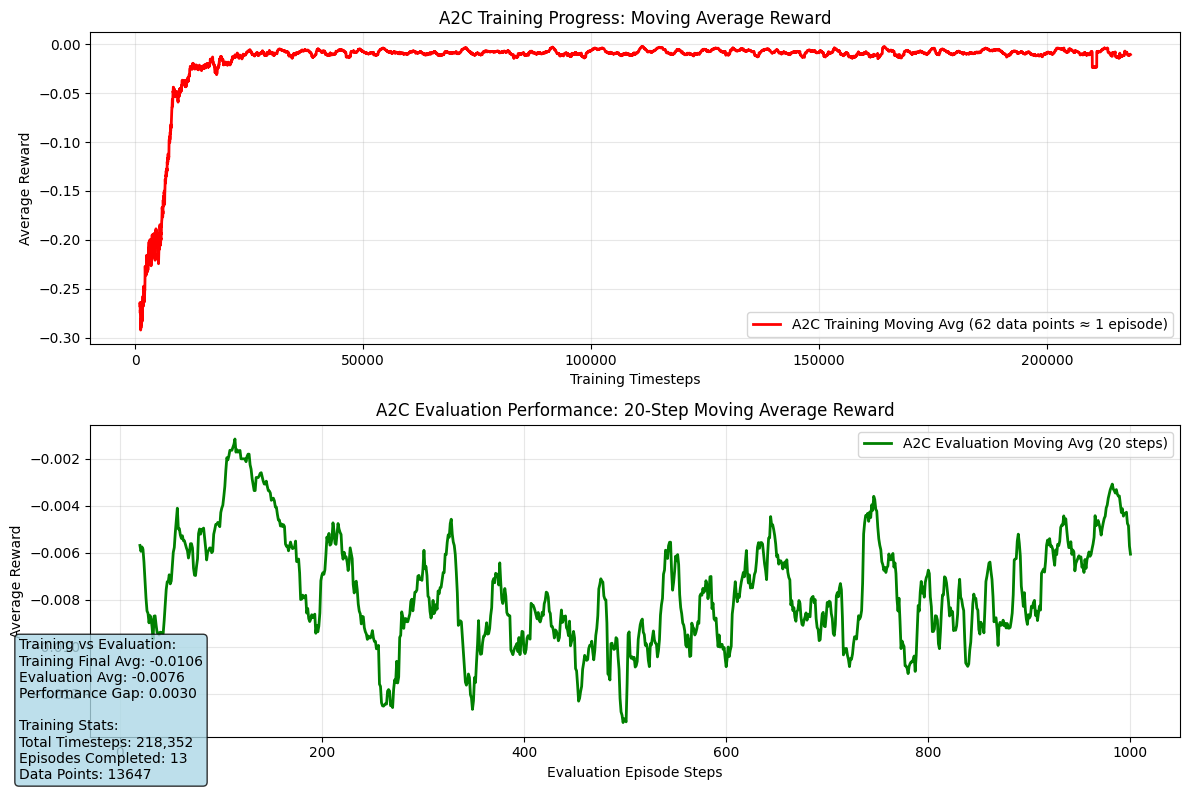


FINAL SUMMARY
Algorithm: A2C
Training completed in: 114.66 seconds
Total training timesteps: 1000000
Episodes completed during training: 13
Final cumulative reward: -221.7441
Average reward per episode: -17.0572
Average evaluation reward: -0.0076 ± 0.0069
Average packet loss rate: 0.0080 ± 0.0011
Average alpha value: 0.0100


In [4]:
# Configuration - change these parameters as needed
ALGORITHM = "A2C"           # Options: "SAC", "PPO", "A2C", "TD3", "DQN"
TIMESTEPS = 1000000         # Training timesteps
TIMESTEPS_PER_EPISODE = 1000
N_ENVS = 16
SAVEPATH = f"Results/DrlAgent/{ALGORITHM}"
AGENTNAME = f"config{configIdx}"
OBVMODE = "perfect"
# Run training and evaluation

model, results, callback = main(
    envParams,
    simEnv,
    save_path=SAVEPATH,
    agent_name=AGENTNAME,
    algorithm_name=ALGORITHM, 
    total_timesteps=TIMESTEPS, 
    timesteps_per_episode=TIMESTEPS_PER_EPISODE,
    obvMode=OBVMODE,
    n_envs=N_ENVS,
    early_stop_threshold=0.1,      # Stop if moving avg improves by 5% from minimum
    min_steps_before_stop=5000,     # Don't allow early stopping before 5000 steps
    moving_avg_window=5000           # Use 100 data points for moving average
)

In [5]:
#from stable_baselines3 import SAC
#model = SAC.load(f"{save_path}/{agentName}.zip")



